# Electron acoustic waves

In [1]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper
from py_vlasov.transport_ratios import input_gen, transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

%matplotlib inline

In [2]:
def fast_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def ea_freq(k, theta, aol, the_tp, nc_nh):
    kz, kp = kzkp(k, theta)
    mp_me = 1836
    num = kz * np.sqrt(0.5 * nc_nh/(1+nc_nh) * the_tp * mp_me)
    k_rhose_2 = kp**2 * 0.5 * nc_nh/(1+nc_nh) * the_tp / mp_me
    kp_debye_2 = (kz**2+kp**2) * 0.5 * aol**2 * the_tp
    denom = np.sqrt(1 + k_rhose_2 + kp_debye_2)
    print(denom)
    return num / denom


    
def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

Given that $$v_{Te, h} = 0.6 c \omega_{ce} \cos\theta / \omega_{pe}$$

$$\beta_p = \frac{T_p}{T_e} 0.36 \cos{\theta}^2$$

In [3]:
theta = 10
wpe_wce = 4
# wpe_wce = 1
the_tp = 60
# the_tp = 1
fac = 0.6

# ===============

aol = 1/np.sqrt(1836)/wpe_wce
betap = 1/the_tp * np.cos(np.deg2rad(theta))**2 * 2* fac**2
print(betap)
# betap = 1e-4

print('aol = {0:.4g}'.format(aol))
print('beta_p = {0:.4g}'.format(betap))
print('beta_e = {0:.4g}'.format(betap * the_tp))

0.0116381557247
aol = 0.005835
beta_p = 0.01164
beta_e = 0.6983


In [5]:
tc_th = 1e-3
nh_nc = 1

t_list=[1., the_tp, the_tp * tc_th]
a_list=[1., 1., 1.]
n_list=[1., nh_nc/(1+nh_nc),1/(1+nh_nc)] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0.,0.,0.]
n = 10
method = 'pade'

kdi = 1

target_kde = 5
target_kdi = target_kde * np.sqrt(1836)

k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)
print(k, kz, kp)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

0.107880284226 0.106241340303 0.0187332147621


In [6]:
target_k = kdi_2_krhoi(target_kdi, betap)
print('target_k = {0:.2f}'.format(target_k))
print('target_kde = {0:.3g}'.format(target_kdi / np.sqrt(1836.)))

# seed_freq = fast_freq(k, theta, betap)
seed_freq = ea_freq(k, theta, aol, the_tp, nc_nh=n_list[2]/n_list[1])
f = lambda wrel:\
    real_imag(oblique_wrapper(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'pade', n = 10, \
                              aol=aol))
guess = seed_freq * (1-.5j) #* .6
# guess = wr + 1j * wi
# guess = 123 - 115j
print('seed_freq = {0:.3g}'.format(guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(guess))

print(wr)
print(wi)
print(wr/1836/np.cos(np.deg2rad(theta)))
freq = follow_k(guess, target_k, param,
                log_incrmt = 0.02, incrmt_method = 'log')

target_k = 23.11
target_kde = 5
1.00000737621
seed_freq = 17.6-14.1j
17.8374632979
-9.89785080111
0.00986526956491


In [7]:
freq_arr = np.array(freq[-1])
print(freq_arr[::5])

[   17.83746330   -9.8978508j     19.69418612  -10.92815607j
    21.74416974  -12.06571189j    24.00752745  -13.32168336j
    26.50646493  -14.70839823j    29.26549757  -16.23946804j
    32.31169036  -17.92992199j    35.67492249  -19.79635488j
    39.38817932  -21.85709053j    43.48787438  -24.13236249j
    48.01420454  -26.64451389j    53.01154169  -29.41821859j
    58.52886456  -32.4807262j     64.62023500  -35.86213374j
    71.34532317  -39.59568748j    78.76998705  -43.71811903j
    86.96691258  -48.27002072j    96.01632195  -53.29626659j
   106.00676010  -58.84648691j   117.03597294  -64.97560598j
   129.21189683  -71.74445508j   142.65378901  -79.22047304j
   157.49354414  -87.47850385j   173.87726457  -96.6016879j
   191.96718003 -106.68240966j   211.94403662 -117.82319111j
   234.01007569 -130.13726065j   258.39255239 -143.74811819j
   285.34645588 -158.78674785j   315.15120786 -175.38736156j
   348.09830613 -193.69379815j   384.48948033 -213.88744443j
   424.66166065 -236.2140

In [8]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2) /np.sqrt(1836) / np.sqrt(betap)
kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(freq_arr))

In [9]:
kde_whistler = np.load('data/whistler_kde.npy')
freq_whistler = np.load('data/whistler_freq_nh_02.npy')

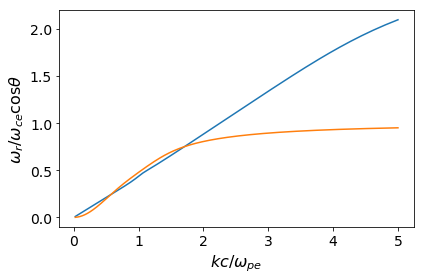

In [10]:
plt.plot(kde_list, freq_arr.real/1836/np.cos(np.deg2rad(theta)))
plt.plot(kde_whistler, freq_whistler.real)
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_r/\omega_{ce} \cos \theta $')
# plt.ylim([0, .1])
# plt.xlim([0, .5])
plt.tight_layout()
# plt.savefig('electron_acoustic_dispersion_real_1.png')

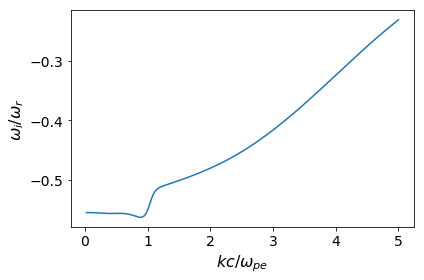

In [11]:
# plt.plot(kde_list, freq_arr.imag/1836/np.cos(np.deg2rad(theta)))
plt.plot(kde_list, freq_arr.imag/freq_arr.real)
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_r $')
plt.tight_layout()
# plt.savefig('electron_acoustic_dispersion_imag_1.png')

# Transport ratio

In [30]:
k_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2)
k_start = kdi_2_krhoi(kdi, betap)
k_list = np.logspace(np.log10(k_start), np.log10(k_end), len(freq_arr))

ex_ez_list = []
ey_ez_list = []
by_bx_list = []

for i in range(len(k_list)):
    freq_i = freq_arr[i]
    kz, kp = kzkp(k_list[i], theta)
    inp = input_gen(freq_i, kp, kz, betap)
    tr = transport_ratios(inp, print_result = False)
    eigen_e = tr['eigen_e']
    kvec = np.array([kp, 0, kz])
    khat = kvec/np.linalg.norm(kvec)
    ez_prime = np.dot(eigen_e, khat) * khat
    ey_prime = np.array([0, eigen_e[1], 0])
    ex_prime = eigen_e - ez_prime - ey_prime
    ex_ez = np.linalg.norm(ex_prime) / np.linalg.norm(ez_prime)
    ey_ez = np.linalg.norm(ey_prime) / np.linalg.norm(ez_prime)
    ex_ez_list.append(ex_ez)
    ey_ez_list.append(ey_ez)
    
    eigen_b = np.cross(kvec, eigen_e)
    bz_prime = np.dot(eigen_b, khat) * khat
    by_prime = np.array([0, eigen_b[1], 0])
    bx_prime = eigen_b - bz_prime - by_prime
    by_bx = np.linalg.norm(bx_prime) / np.linalg.norm(by_prime)
    by_bx_list.append(by_bx)

/Users/Tong/Google_Drive/research/packages/vlasov_solver/py_vlasov/transport_ratios.py:118: RuntimeWarning: divide by zero encountered in cdouble_scalars
  p_b_k = -1/alpha_xi
/Users/Tong/Google_Drive/research/packages/vlasov_solver/py_vlasov/transport_ratios.py:118: RuntimeWarning: invalid value encountered in cdouble_scalars
  p_b_k = -1/alpha_xi
/Users/Tong/Envs/science/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in double_scalars


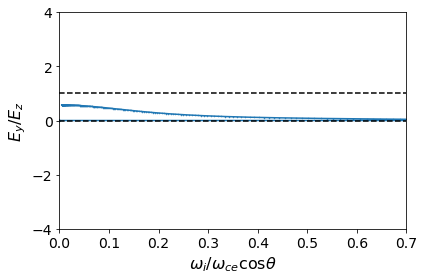

In [31]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), ex_ez_list, '.-', markersize = 1)
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$E_y/E_z$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([-4, 4])
plt.xlim([0, 0.7])
plt.tight_layout()
# plt.savefig('ea_eyez_1.png')

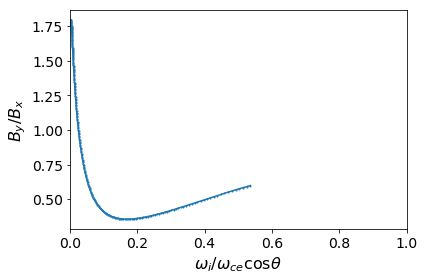

In [256]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), by_bx_list, '-o', markersize=1)
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$B_y/B_x$')
# plt.axhline(1, linestyle='dashed', color='k')
# plt.ylim([0.8, 2.6])
plt.xlim([0, 1.])
plt.tight_layout()
# plt.savefig('ea_byex_1.png')